In [ ]:
%pip install -Uq matplotlib-label-lines

In [1]:
import numpy as np
import xarray as xr
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
import xarray_einstats.stats as xr_stats

In [3]:
from growthstandards import rv_coords, GrowthStandards, XrCompoundRV
from growthstandards.bcs_ext.scipy_ext import BCCG, BCPE

In [4]:
def coord_da(vs, name, attrs={}):
    return xr.DataArray(vs, dims=name).assign_attrs(attrs).assign_coords({name: lambda da: da})

In [5]:
from scipy.special import ndtr, log_ndtr, ndtri, ndtri_exp

# TODO: use a masked lazy where

def calc_z_score(rv: xr_stats.XrRV, v: float | xr.DataArray, log: bool=False, apply_kwargs=None) -> xr.DataArray:
    coords = rv.coords
    attrs = getattr(rv, "attrs", {})
    if log:
        da = xr.where(v >= rv.median(), -ndtri_exp(rv.logsf(v, apply_kwargs=apply_kwargs)), ndtri_exp(rv.logcdf(v, apply_kwargs=apply_kwargs)))
    else:
        da = xr.where(v >= rv.median(), -ndtri(rv.sf(v, apply_kwargs=apply_kwargs)), ndtri(rv.cdf(v, apply_kwargs=apply_kwargs)))
    return da.assign_attrs(attrs).assign_coords(coords.variables)


def invert_z_score(rv: xr_stats.XrRV, z: float | xr.DataArray, log: bool=False, apply_kwargs=None) -> xr.DataArray:
    coords = rv.coords
    attrs = getattr(rv, "attrs", {})
    if log:
        da = xr.where(z >= 0, rv.isf_exp(log_ndtr(-z), apply_kwargs=apply_kwargs), rv.ppf_exp(log_ndtr(z), apply_kwargs=apply_kwargs))
    else:
        da = xr.where(z >= 0, rv.isf(ndtr(-z), apply_kwargs=apply_kwargs), rv.ppf(ndtr(z), apply_kwargs=apply_kwargs))
    return da.assign_attrs(attrs).assign_coords(coords.variables)

In [6]:
list(GrowthStandards.keys())

['arm_c',
 'bmi_height',
 'bmi_length',
 'brain',
 'csf',
 'head_c',
 'height',
 'length',
 'ss',
 'ts',
 'weight',
 'wfh',
 'wfl',
 'len_hei',
 'bmi',
 'gfl',
 'gfh']

In [7]:
len_rv = GrowthStandards["length"]
hei_rv = GrowthStandards["height"]
gfl_rv = GrowthStandards["gfl"]
gfh_rv = GrowthStandards["gfh"]

growth_len_rv = XrCompoundRV(gfl_rv, len_rv, "length")
growth_hei_rv = XrCompoundRV(gfh_rv, hei_rv, "height")

In [8]:
z_da = coord_da([-3, -2, -1, 0, 1, 2, 3], "z")

inverted_z_scores = [
    invert_z_score(GrowthStandards[k], z_da, apply_kwargs={"keep_attrs": True})
    for k in ("weight", "len_hei", "wfl", "wfh")
] + [
    xr.combine_by_coords([
        invert_z_score(growth_len_rv, z_da, apply_kwargs={"keep_attrs": True}),
        invert_z_score(growth_hei_rv, z_da, apply_kwargs={"keep_attrs": True}),
    ], combine_attrs="drop_conflicts"
    ).assign_attrs(long_name="Growth Metric")
]
# inverted_z_scores

/home/ethanyu/anthro-growthstandards-main/growthstandards/xr_stats_ext.py:139: RuntimeWarning: some derivatives were zero
  return np.clip(optimize.newton(f, x0, fprime=fprime), x_min, x_max)
/home/ethanyu/anthro-growthstandards-main/growthstandards/xr_stats_ext.py:139: RuntimeWarning: some derivatives were zero
  return np.clip(optimize.newton(f, x0, fprime=fprime), x_min, x_max)
/home/ethanyu/anthro-growthstandards-main/growthstandards/xr_stats_ext.py:139: RuntimeWarning: some derivatives were zero
  return np.clip(optimize.newton(f, x0, fprime=fprime), x_min, x_max)
/home/ethanyu/.local/lib/python3.10/site-packages/scipy/optimize/_zeros_py.py:427: RuntimeWarning: overflow encountered in divide
  dp = fval[nz_der] / fder[nz_der]
/home/ethanyu/anthro-growthstandards-main/growthstandards/xr_stats_ext.py:139: RuntimeWarning: some derivatives were zero
  return np.clip(optimize.newton(f, x0, fprime=fprime), x_min, x_max)


In [9]:
from labellines import labelLines as label_lines

ValueError: These variables cannot be found in this dataset: ['sex_enum']

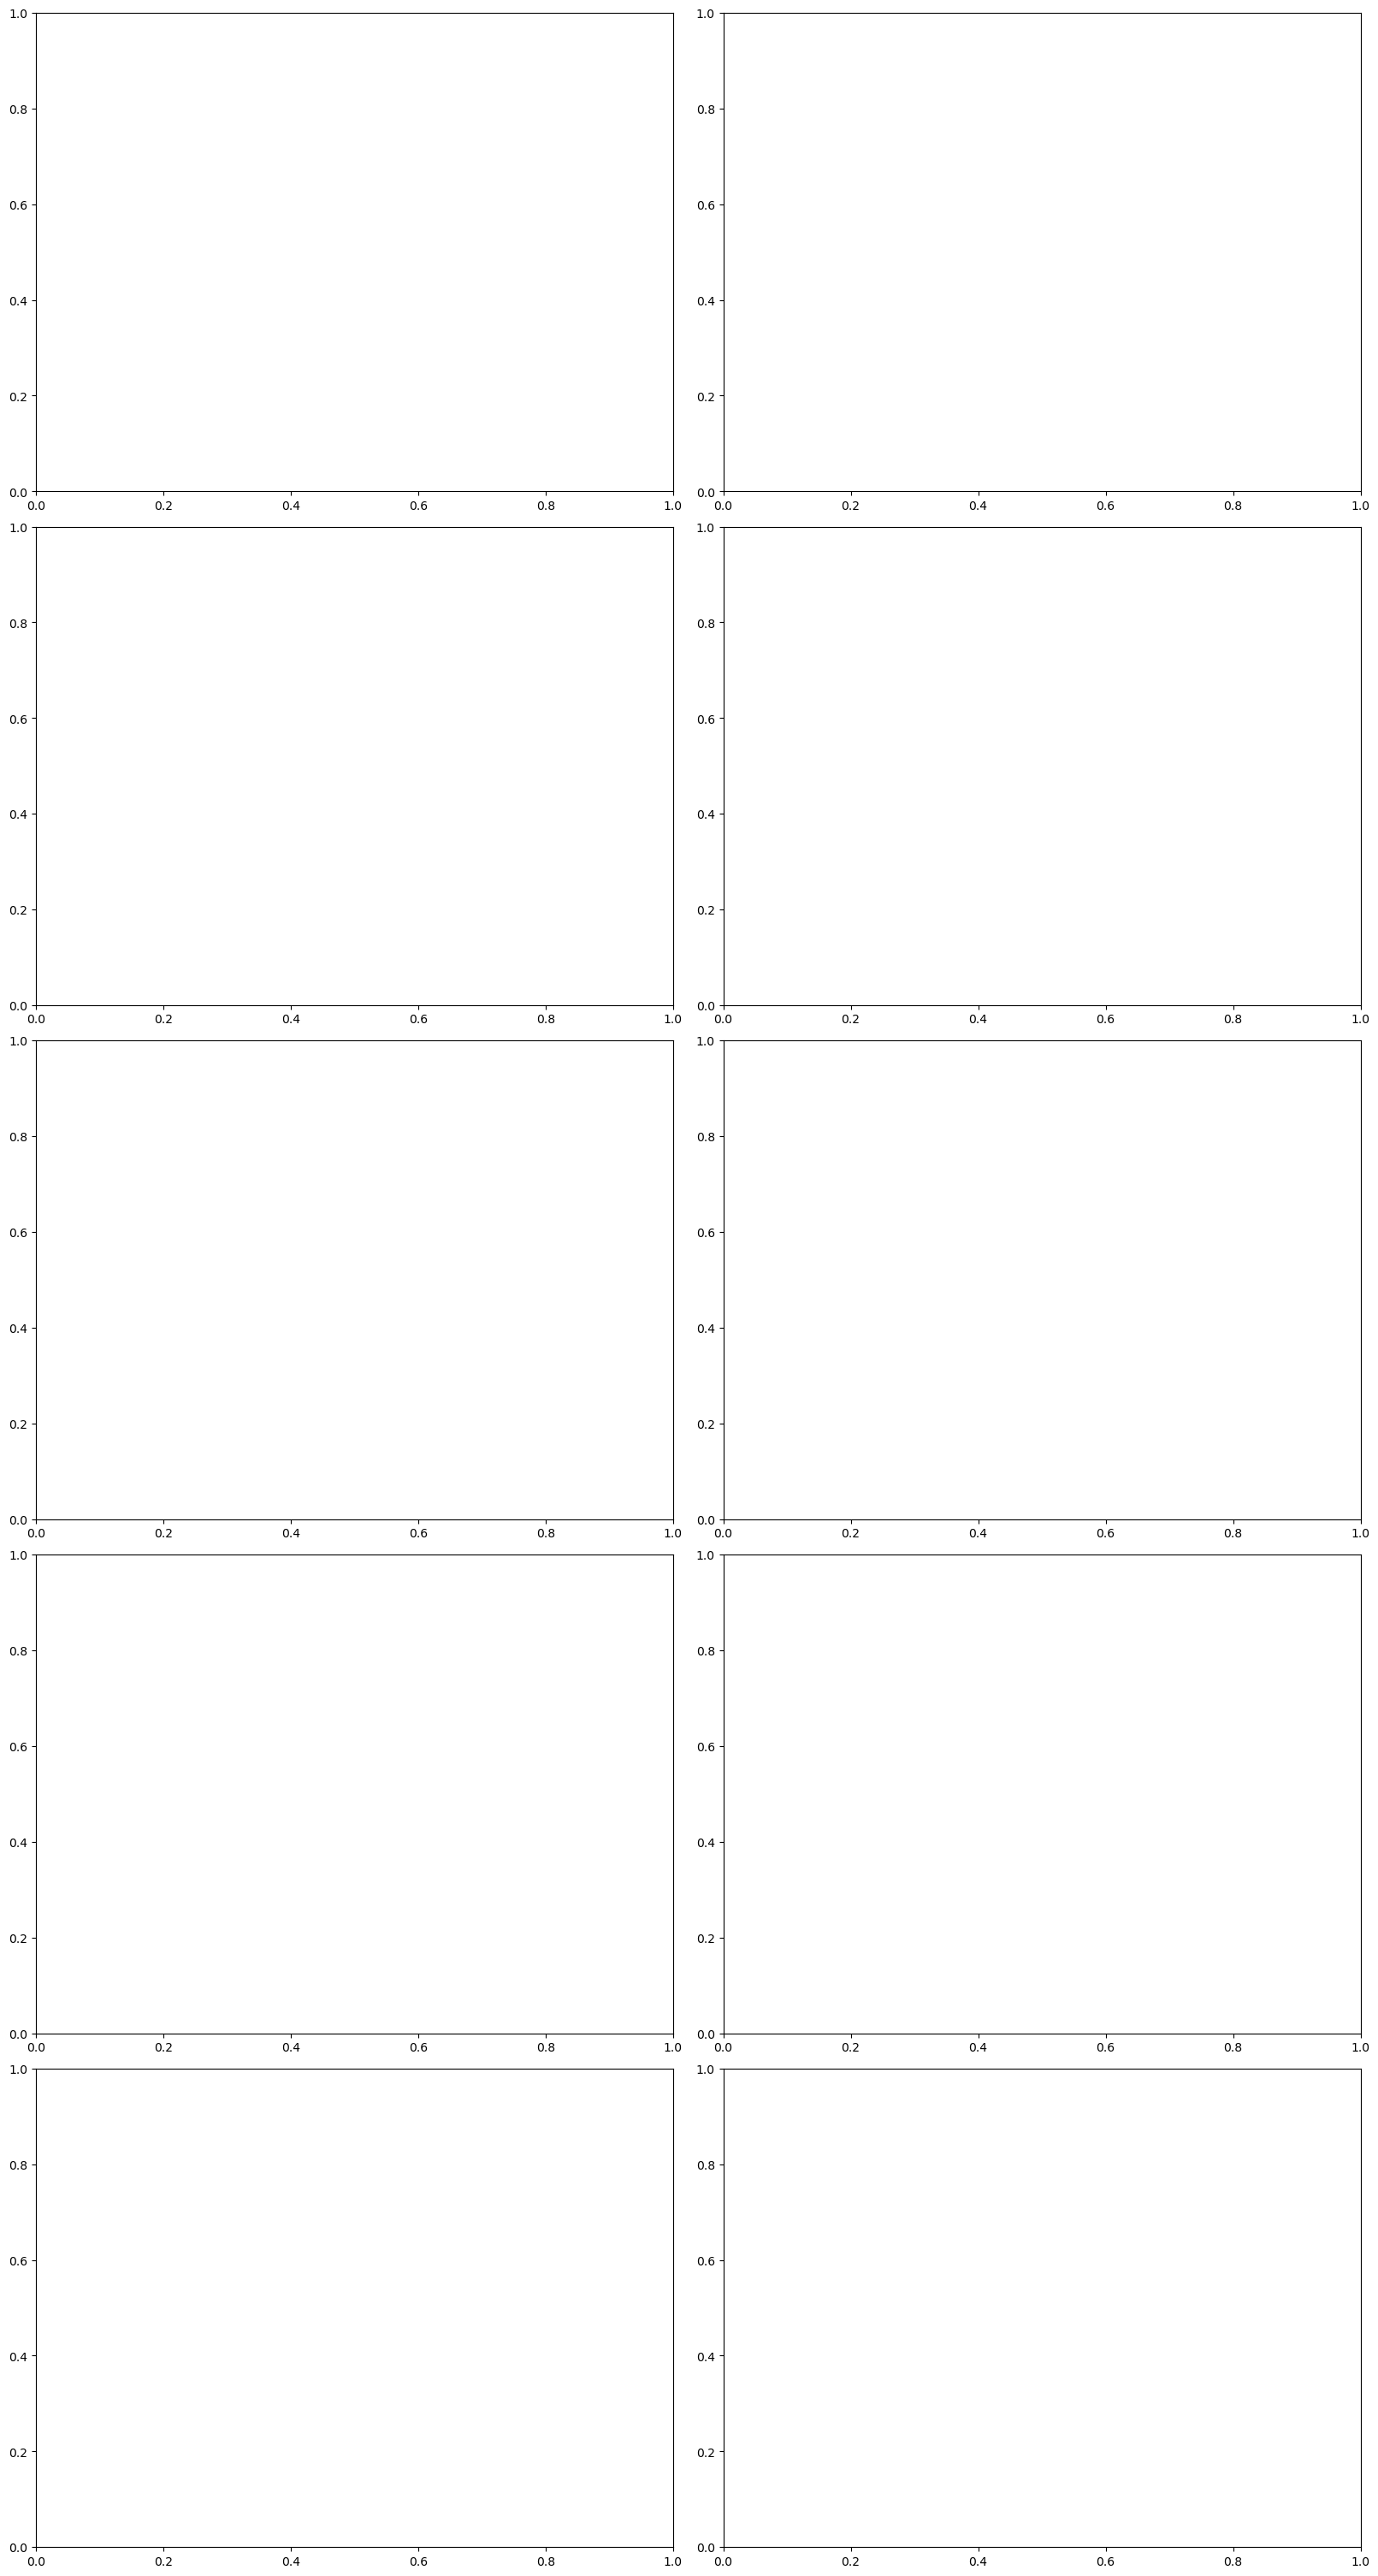

In [10]:
# z_c_map = {0: "C0", 2: "C1", 3: "C2"}
z_c_map = {i: f"C{i}" for i in range(4)}

n = len(inverted_z_scores)
fig, axs = plt.subplots(n, 2, figsize=(16, 6 * n), layout="constrained")
for raxs, da in zip(axs, inverted_z_scores):
    da = da.drop_vars("sex_enum")
    for i, ax in enumerate(raxs):
        lines = []
        for z in z_da:
            c = z_c_map[abs(int(z))]
            _lines = da.isel(sex=i).sel(z=z).plot.line(ax=ax, c=c, label=f"{int(z)}")
            lines.extend(_lines)
        label_lines(lines, fontsize=16)
        ax.autoscale(enable=True, axis="x", tight=True)
        name = da.attrs.get("long_name", da.name)
        s = da.isel(sex=i)["sex"].item()
        ax.set_title(f"{name} ({s})")